# Deep cortical reinforcement learning: Policy gradients + Q-learning + GAN


In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import gym

## Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('MountainCarContinuous-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [3]:
env.reset()
batch = []
for _ in range(1111):
    #env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    batch.append([action, state, reward, done, info])
    #print('state, action, reward, done, info:', state, action, reward, done, info)
    if done:
        env.reset()

To shut the window showing the simulation, use `env.close()`.

In [4]:
# env.close()

If you ran the simulation above, we can look at the rewards:

In [5]:
batch[0], 
batch[0][1].shape, state.shape

((4,), (4,))

In [6]:
import numpy as np
actions = np.array([each[0] for each in batch])
states = np.array([each[1] for each in batch])
rewards = np.array([each[2] for each in batch])
dones = np.array([each[3] for each in batch])
infos = np.array([each[4] for each in batch])

In [7]:
# print(rewards[-20:])
print('shapes:', np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print('dtypes:', np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print('states:', np.max(np.array(states)), np.min(np.array(states)))
print('actions:', np.max(np.array(actions)), np.min(np.array(actions)))
# print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print('rewards:', np.max(np.array(rewards)), np.min(np.array(rewards)))

shapes: (1111,) (1111, 4) (1111,) (1111,)
dtypes: float64 float64 int64 bool
states: 3.0512562260349734 -2.7999460165704684
actions: 1 0
rewards: 1.0 1.0


In [8]:
actions[:10]

array([0, 1, 1, 0, 1, 1, 1, 1, 1, 1])

In [9]:
rewards[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [10]:
# import numpy as np
def sigmoid(x, derivative=False):
  return x*(1-x) if derivative else 1/(1+np.exp(-x))

In [11]:
sigmoid(np.max(np.array(rewards))), sigmoid(np.min(np.array(rewards)))

(0.7310585786300049, 0.7310585786300049)

In [12]:
print('rewards:', np.max(np.array(rewards))/100, np.min(np.array(rewards))/100)

rewards: 0.01 0.01


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [13]:
# Data of the model
def model_input(state_size):
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    rate = tf.placeholder(tf.float32, [], name='rate')
    return states, actions, targetQs, rate

In [14]:
# How to use batch-norm
#   x_norm = tf.layers.batch_normalization(x, training=training)

#   # ...

#   update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
#   with tf.control_dependencies(update_ops):
#     train_op = optimizer.minimize(loss)

In [15]:
# training: Either a Python boolean, or a TensorFlow boolean scalar tensor (e.g. a placeholder). 
# Whether to return the output in: 
# training mode (normalized with statistics of the current batch) or 
# inference mode (normalized with moving statistics). 
# NOTE: make sure to set this parameter correctly, or else your training/inference will not work properly.

In [16]:
# Generator/Controller: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [17]:
# Discriminator/Dopamine: Reward function/planner/naviator/advisor/supervisor/cortical columns
def discriminator(states, actions, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Fusion/merge states and actions/ SA/ SM
        x_fused = tf.concat(axis=1, values=[states, actions])
        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=x_fused, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        #predictions = tf.nn.softmax(logits)

        # return rewards logits
        return logits

In [18]:
def model_loss(action_size, hidden_size, states, actions, targetQs, rate):
    # G
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    neg_log_prob_actions = tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                      labels=actions_labels)
    g_loss = tf.reduce_mean(neg_log_prob_actions * targetQs)
    
    # D
    Qs = discriminator(actions=actions_logits, hidden_size=hidden_size, states=states)
    d_lossR = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=tf.reshape(Qs, shape=[-1]),
                                                                     labels=rate * tf.ones_like(targetQs)))
    #d_lossQ = tf.reduce_mean(tf.square(tf.reshape(Qs, shape=[-1]) - targetQs))
    d_lossQ = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=tf.reshape(Qs, shape=[-1]),
                                                                     labels=tf.nn.sigmoid(targetQs)))
    d_loss = d_lossR + d_lossQ

    return actions_logits, Qs, g_loss, d_loss, d_lossR, d_lossQ

In [19]:
# Optimizating/training/learning G & D
def model_opt(g_loss, d_loss, learning_rate):
    """
    Get optimization operations in order
    :param g_loss: Generator loss Tensor for action prediction
    :param d_loss: Discriminator loss Tensor for reward prediction for generated/prob/logits action
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)

    return g_opt, d_opt

In [20]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs, self.rate = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.Qs_logits, self.g_loss, self.d_loss, self.d_lossR, self.d_lossQ = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, # model input
            targetQs=self.targetQs, rate=self.rate) # model input
        
        # Update the model: backward pass and backprop
        self.g_opt, self.d_opt = model_opt(g_loss=self.g_loss, d_loss=self.d_loss, learning_rate=learning_rate)

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [21]:
print('state size:{}'.format(states.shape), 
      'actions:{}'.format(actions.shape)) 
print('action size:{}'.format(np.max(actions) - np.min(actions)+1))

state size:(1111, 4) actions:(1111,)
action size:2


In [22]:
# Training parameters
# Network parameters
state_size = 4               # number of units for the input state/observation -- simulation
action_size = 2              # number of units for the output actions -- simulation
hidden_size = 64             # number of units in each Q-network hidden layer -- simulation
learning_rate = 0.001          # learning rate for adam

In [23]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [25]:
from collections import deque
episodes_total_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window
saver = tf.train.Saver()
rewards_list, g_loss_list, d_loss_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Training episodes/epochs
    for ep in range(1111):
        batch = [] # every data batch
        total_reward = 0
        state = env.reset() # env first state

        # Training steps/batches
        while True:
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
            action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            batch.append([state, action, next_state, reward, float(done)])
            total_reward += reward
            state = next_state
            if done is True:
                break
                
        # Episode total reward and success rate
        episodes_total_reward.append(total_reward) # stopping criteria
        rate = total_reward/ 500 # success is 500 points: 0-1

        # Training using batches
        states = np.array([each[0] for each in batch])
        actions = np.array([each[1] for each in batch])
        next_states = np.array([each[2] for each in batch])
        rewards = np.array([each[3] for each in batch])
        dones = np.array([each[4] for each in batch])
        nextQs_logits = sess.run(model.Qs_logits, feed_dict={model.states: next_states})
        nextQs = nextQs_logits.reshape([-1]) * (1-dones)
        targetQs = rewards + (0.99*nextQs)
        g_loss, d_loss, d_lossR, d_lossQ, _, _ = sess.run([model.g_loss, model.d_loss, 
                                                           model.d_lossR, model.d_lossQ, 
                                                           model.g_opt, model.d_opt],
                                                          feed_dict = {model.states: states, 
                                                                       model.actions: actions,
                                                                       model.targetQs: targetQs,
                                                                       model.rate: rate})
        # Print out
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episodes_total_reward)),
              'rate:{:.4f}'.format(rate),
              'gloss:{:.4f}'.format(g_loss),
              'dloss:{:.4f}'.format(d_loss),
              'dlossR:{:.4f}'.format(d_lossR),
              'dlossQ:{:.4f}'.format(d_lossQ))
        # Ploting out
        rewards_list.append([ep, np.mean(episodes_total_reward)])
        g_loss_list.append([ep, g_loss])
        d_loss_list.append([ep, d_loss])
        # Break episode/epoch loop
        if np.mean(episodes_total_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:8.0000 rate:0.0160 gloss:0.7581 dloss:1.4523 dlossR:0.8132 dlossQ:0.6391
Episode:1 meanR:8.5000 rate:0.0180 gloss:0.6809 dloss:1.4441 dlossR:0.7995 dlossQ:0.6446
Episode:2 meanR:8.6667 rate:0.0180 gloss:0.6002 dloss:1.4266 dlossR:0.7679 dlossQ:0.6587
Episode:3 meanR:8.7500 rate:0.0180 gloss:0.5307 dloss:1.4120 dlossR:0.7413 dlossQ:0.6707
Episode:4 meanR:9.0000 rate:0.0200 gloss:0.4605 dloss:1.3976 dlossR:0.7144 dlossQ:0.6832
Episode:5 meanR:9.3333 rate:0.0220 gloss:0.3925 dloss:1.3833 dlossR:0.6872 dlossQ:0.6961
Episode:6 meanR:9.2857 rate:0.0180 gloss:0.3622 dloss:1.3673 dlossR:0.6565 dlossQ:0.7108
Episode:7 meanR:9.5000 rate:0.0220 gloss:0.2916 dloss:1.3514 dlossR:0.6255 dlossQ:0.7259
Episode:8 meanR:9.5556 rate:0.0200 gloss:0.2587 dloss:1.3371 dlossR:0.5980 dlossQ:0.7391
Episode:9 meanR:9.5000 rate:0.0180 gloss:0.2323 dloss:1.3244 dlossR:0.5738 dlossQ:0.7506
Episode:10 meanR:9.4545 rate:0.0180 gloss:0.2040 dloss:1.3104 dlossR:0.5471 dlossQ:0.7633
Episode:11 meanR:9.5

Episode:92 meanR:9.4409 rate:0.0180 gloss:-0.0001 dloss:1.1892 dlossR:0.3519 dlossQ:0.8373
Episode:93 meanR:9.4362 rate:0.0180 gloss:0.0003 dloss:1.1914 dlossR:0.3548 dlossQ:0.8366
Episode:94 meanR:9.4421 rate:0.0200 gloss:0.0001 dloss:1.1934 dlossR:0.3603 dlossQ:0.8331
Episode:95 meanR:9.4479 rate:0.0200 gloss:0.0005 dloss:1.1953 dlossR:0.3628 dlossQ:0.8326
Episode:96 meanR:9.4433 rate:0.0180 gloss:-0.0001 dloss:1.1890 dlossR:0.3518 dlossQ:0.8372
Episode:97 meanR:9.4388 rate:0.0180 gloss:-0.0004 dloss:1.1859 dlossR:0.3482 dlossQ:0.8377
Episode:98 meanR:9.4444 rate:0.0200 gloss:-0.0016 dloss:1.1856 dlossR:0.3506 dlossQ:0.8350
Episode:99 meanR:9.4300 rate:0.0160 gloss:-0.0013 dloss:1.1793 dlossR:0.3363 dlossQ:0.8431
Episode:100 meanR:9.4500 rate:0.0200 gloss:-0.0013 dloss:1.1856 dlossR:0.3507 dlossQ:0.8348
Episode:101 meanR:9.4600 rate:0.0200 gloss:-0.0013 dloss:1.1872 dlossR:0.3531 dlossQ:0.8342
Episode:102 meanR:9.4600 rate:0.0180 gloss:-0.0002 dloss:1.1889 dlossR:0.3522 dlossQ:0.8367

Episode:187 meanR:9.3400 rate:0.0180 gloss:-0.0035 dloss:1.1814 dlossR:0.3463 dlossQ:0.8351
Episode:188 meanR:9.3300 rate:0.0200 gloss:-0.0048 dloss:1.1794 dlossR:0.3470 dlossQ:0.8324
Episode:189 meanR:9.3200 rate:0.0160 gloss:-0.0053 dloss:1.1704 dlossR:0.3284 dlossQ:0.8420
Episode:190 meanR:9.3200 rate:0.0200 gloss:-0.0050 dloss:1.1777 dlossR:0.3450 dlossQ:0.8327
Episode:191 meanR:9.3300 rate:0.0180 gloss:-0.0031 dloss:1.1829 dlossR:0.3479 dlossQ:0.8350
Episode:192 meanR:9.3200 rate:0.0160 gloss:-0.0020 dloss:1.1825 dlossR:0.3435 dlossQ:0.8390
Episode:193 meanR:9.3200 rate:0.0180 gloss:-0.0022 dloss:1.1876 dlossR:0.3540 dlossQ:0.8336
Episode:194 meanR:9.3200 rate:0.0200 gloss:-0.0017 dloss:1.1972 dlossR:0.3696 dlossQ:0.8276
Episode:195 meanR:9.3300 rate:0.0220 gloss:-0.0026 dloss:1.1990 dlossR:0.3746 dlossQ:0.8244
Episode:196 meanR:9.3400 rate:0.0200 gloss:-0.0053 dloss:1.1783 dlossR:0.3460 dlossQ:0.8323
Episode:197 meanR:9.3500 rate:0.0200 gloss:-0.0053 dloss:1.1743 dlossR:0.3409 dl

Episode:283 meanR:9.3700 rate:0.0200 gloss:-0.0074 dloss:1.1795 dlossR:0.3480 dlossQ:0.8315
Episode:284 meanR:9.3900 rate:0.0200 gloss:-0.0115 dloss:1.1667 dlossR:0.3329 dlossQ:0.8338
Episode:285 meanR:9.3800 rate:0.0180 gloss:-0.0127 dloss:1.1622 dlossR:0.3239 dlossQ:0.8383
Episode:286 meanR:9.3800 rate:0.0200 gloss:-0.0094 dloss:1.1726 dlossR:0.3398 dlossQ:0.8328
Episode:287 meanR:9.3800 rate:0.0180 gloss:-0.0084 dloss:1.1741 dlossR:0.3382 dlossQ:0.8359
Episode:288 meanR:9.3700 rate:0.0180 gloss:-0.0036 dloss:1.1852 dlossR:0.3525 dlossQ:0.8328
Episode:289 meanR:9.3800 rate:0.0180 gloss:0.0006 dloss:1.1943 dlossR:0.3638 dlossQ:0.8305
Episode:290 meanR:9.3700 rate:0.0180 gloss:0.0024 dloss:1.1991 dlossR:0.3704 dlossQ:0.8288
Episode:291 meanR:9.3600 rate:0.0160 gloss:0.0169 dloss:1.1903 dlossR:0.3508 dlossQ:0.8395
Episode:292 meanR:9.3700 rate:0.0180 gloss:0.0232 dloss:1.2063 dlossR:0.3753 dlossQ:0.8310
Episode:293 meanR:9.3700 rate:0.0180 gloss:0.0263 dloss:1.2119 dlossR:0.3828 dlossQ:

Episode:378 meanR:9.3100 rate:0.0180 gloss:-0.0089 dloss:1.1790 dlossR:0.3447 dlossQ:0.8343
Episode:379 meanR:9.3200 rate:0.0200 gloss:-0.0103 dloss:1.1835 dlossR:0.3539 dlossQ:0.8296
Episode:380 meanR:9.3100 rate:0.0200 gloss:-0.0122 dloss:1.1784 dlossR:0.3475 dlossQ:0.8308
Episode:381 meanR:9.3000 rate:0.0180 gloss:-0.0107 dloss:1.1781 dlossR:0.3439 dlossQ:0.8342
Episode:382 meanR:9.2900 rate:0.0180 gloss:-0.0228 dloss:1.1565 dlossR:0.3162 dlossQ:0.8403
Episode:383 meanR:9.2800 rate:0.0180 gloss:-0.0145 dloss:1.1707 dlossR:0.3350 dlossQ:0.8357
Episode:384 meanR:9.2800 rate:0.0200 gloss:-0.0170 dloss:1.1694 dlossR:0.3339 dlossQ:0.8355
Episode:385 meanR:9.2800 rate:0.0180 gloss:-0.0199 dloss:1.1701 dlossR:0.3328 dlossQ:0.8373
Episode:386 meanR:9.2700 rate:0.0180 gloss:-0.0157 dloss:1.1844 dlossR:0.3509 dlossQ:0.8335
Episode:387 meanR:9.2800 rate:0.0200 gloss:-0.0134 dloss:1.1988 dlossR:0.3733 dlossQ:0.8255
Episode:388 meanR:9.2900 rate:0.0200 gloss:-0.0114 dloss:1.1813 dlossR:0.3508 dl

Episode:471 meanR:9.1900 rate:0.0160 gloss:-0.0377 dloss:1.1589 dlossR:0.3184 dlossQ:0.8405
Episode:472 meanR:9.1700 rate:0.0160 gloss:-0.0101 dloss:1.1674 dlossR:0.3252 dlossQ:0.8422
Episode:473 meanR:9.1800 rate:0.0200 gloss:-0.0107 dloss:1.1762 dlossR:0.3447 dlossQ:0.8314
Episode:474 meanR:9.1800 rate:0.0160 gloss:-0.0057 dloss:1.1760 dlossR:0.3363 dlossQ:0.8397
Episode:475 meanR:9.2000 rate:0.0200 gloss:-0.0064 dloss:1.1876 dlossR:0.3581 dlossQ:0.8295
Episode:476 meanR:9.1900 rate:0.0180 gloss:-0.0027 dloss:1.1906 dlossR:0.3593 dlossQ:0.8313
Episode:477 meanR:9.1900 rate:0.0200 gloss:-0.0046 dloss:1.1931 dlossR:0.3651 dlossQ:0.8279
Episode:478 meanR:9.1900 rate:0.0180 gloss:-0.0016 dloss:1.1901 dlossR:0.3581 dlossQ:0.8320
Episode:479 meanR:9.2000 rate:0.0220 gloss:-0.0046 dloss:1.2016 dlossR:0.3800 dlossQ:0.8216
Episode:480 meanR:9.2000 rate:0.0200 gloss:-0.0075 dloss:1.1825 dlossR:0.3517 dlossQ:0.8309
Episode:481 meanR:9.2100 rate:0.0200 gloss:-0.0087 dloss:1.1754 dlossR:0.3427 dl

Episode:567 meanR:9.1300 rate:0.0200 gloss:-0.0182 dloss:1.1770 dlossR:0.3446 dlossQ:0.8324
Episode:568 meanR:9.1300 rate:0.0180 gloss:-0.0241 dloss:1.1679 dlossR:0.3311 dlossQ:0.8369
Episode:569 meanR:9.1200 rate:0.0180 gloss:-0.0054 dloss:1.1889 dlossR:0.3573 dlossQ:0.8316
Episode:570 meanR:9.1100 rate:0.0160 gloss:-0.0262 dloss:1.1635 dlossR:0.3218 dlossQ:0.8417
Episode:571 meanR:9.1100 rate:0.0160 gloss:-0.0270 dloss:1.1649 dlossR:0.3235 dlossQ:0.8414
Episode:572 meanR:9.1200 rate:0.0180 gloss:-0.0093 dloss:1.1824 dlossR:0.3492 dlossQ:0.8332
Episode:573 meanR:9.1100 rate:0.0180 gloss:-0.0047 dloss:1.1887 dlossR:0.3578 dlossQ:0.8309
Episode:574 meanR:9.1300 rate:0.0200 gloss:-0.0121 dloss:1.1820 dlossR:0.3522 dlossQ:0.8298
Episode:575 meanR:9.1300 rate:0.0200 gloss:-0.0115 dloss:1.1828 dlossR:0.3535 dlossQ:0.8294
Episode:576 meanR:9.1300 rate:0.0180 gloss:-0.0067 dloss:1.1809 dlossR:0.3474 dlossQ:0.8335
Episode:577 meanR:9.1200 rate:0.0180 gloss:-0.0053 dloss:1.1831 dlossR:0.3508 dl

Episode:663 meanR:9.3900 rate:0.0200 gloss:-0.0081 dloss:1.1841 dlossR:0.3552 dlossQ:0.8289
Episode:664 meanR:9.3900 rate:0.0180 gloss:-0.0055 dloss:1.1847 dlossR:0.3534 dlossQ:0.8313
Episode:665 meanR:9.4000 rate:0.0200 gloss:-0.0122 dloss:1.1776 dlossR:0.3475 dlossQ:0.8301
Episode:666 meanR:9.4200 rate:0.0200 gloss:-0.0121 dloss:1.1801 dlossR:0.3510 dlossQ:0.8291
Episode:667 meanR:9.4200 rate:0.0200 gloss:-0.0135 dloss:1.1759 dlossR:0.3457 dlossQ:0.8302
Episode:668 meanR:9.4200 rate:0.0180 gloss:-0.0114 dloss:1.1739 dlossR:0.3400 dlossQ:0.8339
Episode:669 meanR:9.4100 rate:0.0160 gloss:-0.0105 dloss:1.1726 dlossR:0.3344 dlossQ:0.8382
Episode:670 meanR:9.4100 rate:0.0160 gloss:-0.0078 dloss:1.1756 dlossR:0.3381 dlossQ:0.8375
Episode:671 meanR:9.4100 rate:0.0160 gloss:-0.0059 dloss:1.1794 dlossR:0.3430 dlossQ:0.8365
Episode:672 meanR:9.4100 rate:0.0180 gloss:-0.0054 dloss:1.1920 dlossR:0.3640 dlossQ:0.8281
Episode:673 meanR:9.4100 rate:0.0180 gloss:-0.0061 dloss:1.1899 dlossR:0.3612 dl

Episode:758 meanR:9.1000 rate:0.0180 gloss:-0.0089 dloss:1.1844 dlossR:0.3479 dlossQ:0.8365
Episode:759 meanR:9.0800 rate:0.0160 gloss:-0.0094 dloss:1.1821 dlossR:0.3419 dlossQ:0.8402
Episode:760 meanR:9.0800 rate:0.0200 gloss:-0.0078 dloss:1.1900 dlossR:0.3582 dlossQ:0.8318
Episode:761 meanR:9.0800 rate:0.0180 gloss:-0.0102 dloss:1.1850 dlossR:0.3494 dlossQ:0.8356
Episode:762 meanR:9.0700 rate:0.0180 gloss:0.0097 dloss:1.2281 dlossR:0.4169 dlossQ:0.8112
Episode:763 meanR:9.0600 rate:0.0180 gloss:-0.0118 dloss:1.1850 dlossR:0.3502 dlossQ:0.8348
Episode:764 meanR:9.0700 rate:0.0200 gloss:-0.0043 dloss:1.2134 dlossR:0.3974 dlossQ:0.8160
Episode:765 meanR:9.0700 rate:0.0200 gloss:-0.0089 dloss:1.2051 dlossR:0.3856 dlossQ:0.8195
Episode:766 meanR:9.0600 rate:0.0180 gloss:-0.0183 dloss:1.1763 dlossR:0.3425 dlossQ:0.8338
Episode:767 meanR:9.0600 rate:0.0200 gloss:-0.0257 dloss:1.1657 dlossR:0.3320 dlossQ:0.8337
Episode:768 meanR:9.0600 rate:0.0180 gloss:-0.0304 dloss:1.1527 dlossR:0.3136 dlo

Episode:852 meanR:9.2100 rate:0.0180 gloss:-0.0201 dloss:1.1728 dlossR:0.3377 dlossQ:0.8351
Episode:853 meanR:9.2200 rate:0.0180 gloss:-0.0281 dloss:1.1607 dlossR:0.3239 dlossQ:0.8368
Episode:854 meanR:9.2300 rate:0.0200 gloss:-0.0218 dloss:1.1674 dlossR:0.3350 dlossQ:0.8324
Episode:855 meanR:9.2200 rate:0.0180 gloss:-0.0236 dloss:1.1627 dlossR:0.3257 dlossQ:0.8369
Episode:856 meanR:9.2000 rate:0.0160 gloss:-0.0239 dloss:1.1600 dlossR:0.3177 dlossQ:0.8423
Episode:857 meanR:9.2100 rate:0.0200 gloss:-0.0148 dloss:1.1738 dlossR:0.3422 dlossQ:0.8316
Episode:858 meanR:9.2200 rate:0.0200 gloss:-0.0132 dloss:1.1748 dlossR:0.3429 dlossQ:0.8318
Episode:859 meanR:9.2400 rate:0.0200 gloss:-0.0107 dloss:1.1776 dlossR:0.3465 dlossQ:0.8312
Episode:860 meanR:9.2200 rate:0.0160 gloss:-0.0143 dloss:1.1699 dlossR:0.3296 dlossQ:0.8403
Episode:861 meanR:9.2200 rate:0.0180 gloss:-0.0126 dloss:1.1752 dlossR:0.3405 dlossQ:0.8347
Episode:862 meanR:9.2100 rate:0.0160 gloss:0.0280 dloss:1.2111 dlossR:0.3862 dlo

Episode:955 meanR:11.6300 rate:0.0160 gloss:-0.0163 dloss:1.1801 dlossR:0.3426 dlossQ:0.8375
Episode:956 meanR:11.6500 rate:0.0200 gloss:-0.0149 dloss:1.1869 dlossR:0.3578 dlossQ:0.8291
Episode:957 meanR:11.6400 rate:0.0180 gloss:-0.0159 dloss:1.1748 dlossR:0.3387 dlossQ:0.8361
Episode:958 meanR:11.6300 rate:0.0180 gloss:-0.0178 dloss:1.1664 dlossR:0.3284 dlossQ:0.8381
Episode:959 meanR:11.6300 rate:0.0200 gloss:-0.0175 dloss:1.1692 dlossR:0.3349 dlossQ:0.8342
Episode:960 meanR:11.6500 rate:0.0200 gloss:-0.0168 dloss:1.1701 dlossR:0.3358 dlossQ:0.8342
Episode:961 meanR:11.6500 rate:0.0180 gloss:-0.0198 dloss:1.1665 dlossR:0.3291 dlossQ:0.8374
Episode:962 meanR:11.6700 rate:0.0200 gloss:-0.0187 dloss:1.1758 dlossR:0.3444 dlossQ:0.8314
Episode:963 meanR:11.6600 rate:0.0180 gloss:-0.0192 dloss:1.1753 dlossR:0.3406 dlossQ:0.8347
Episode:964 meanR:11.6800 rate:0.0200 gloss:-0.0180 dloss:1.1851 dlossR:0.3568 dlossQ:0.8283
Episode:965 meanR:11.6800 rate:0.0200 gloss:-0.0186 dloss:1.1867 dloss

Episode:1046 meanR:9.2400 rate:0.0180 gloss:-0.0157 dloss:1.1759 dlossR:0.3418 dlossQ:0.8341
Episode:1047 meanR:9.2400 rate:0.0180 gloss:-0.0165 dloss:1.1773 dlossR:0.3442 dlossQ:0.8332
Episode:1048 meanR:9.2500 rate:0.0180 gloss:-0.0298 dloss:1.1815 dlossR:0.3548 dlossQ:0.8266
Episode:1049 meanR:9.2400 rate:0.0180 gloss:-0.0306 dloss:1.1800 dlossR:0.3527 dlossQ:0.8273
Episode:1050 meanR:9.2400 rate:0.0160 gloss:-0.0157 dloss:1.1748 dlossR:0.3371 dlossQ:0.8377
Episode:1051 meanR:9.2300 rate:0.0180 gloss:-0.0146 dloss:1.1854 dlossR:0.3555 dlossQ:0.8299
Episode:1052 meanR:9.2300 rate:0.0180 gloss:-0.0314 dloss:1.1746 dlossR:0.3452 dlossQ:0.8294
Episode:1053 meanR:9.2300 rate:0.0160 gloss:-0.0131 dloss:1.1794 dlossR:0.3432 dlossQ:0.8361
Episode:1054 meanR:9.2200 rate:0.0180 gloss:-0.0150 dloss:1.1865 dlossR:0.3571 dlossQ:0.8293
Episode:1055 meanR:9.2300 rate:0.0180 gloss:-0.0337 dloss:1.1691 dlossR:0.3379 dlossQ:0.8312
Episode:1056 meanR:9.2100 rate:0.0160 gloss:-0.0139 dloss:1.1804 dloss

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total rewards')

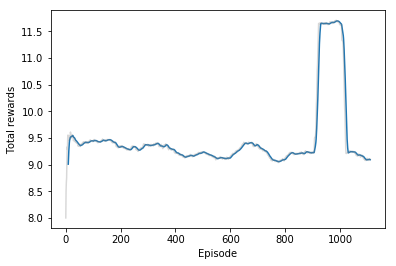

In [27]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'G losses')

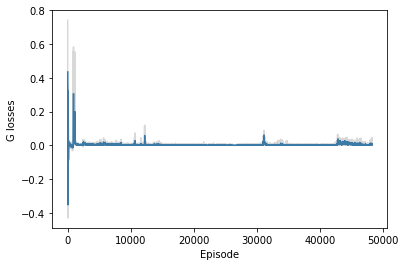

In [35]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'D losses')

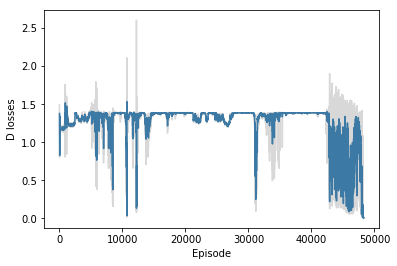

In [36]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [37]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(100):
    #while True:
        state = env.reset()
        total_reward = 0

        # Steps/batches
        #for _ in range(111111111111111111):
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                break
        # Print and break condition
        print('total_reward: {}'.format(total_reward))
        # if total_reward == 500:
        #     break
                
# Closing the env
env.close()

/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500

## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.